In [5]:
import sqlite3
from functools import reduce

import numpy as np

conn = sqlite3.connect("medical.db")
cur = conn.cursor()

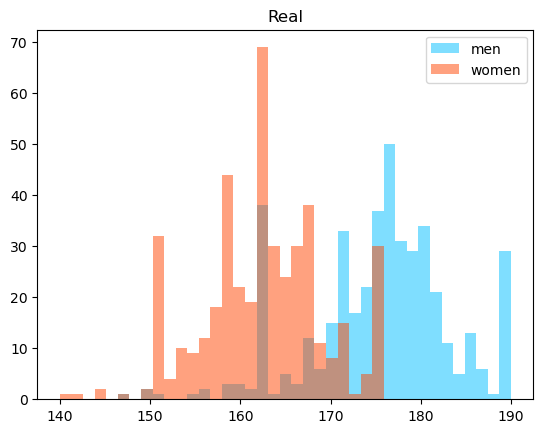

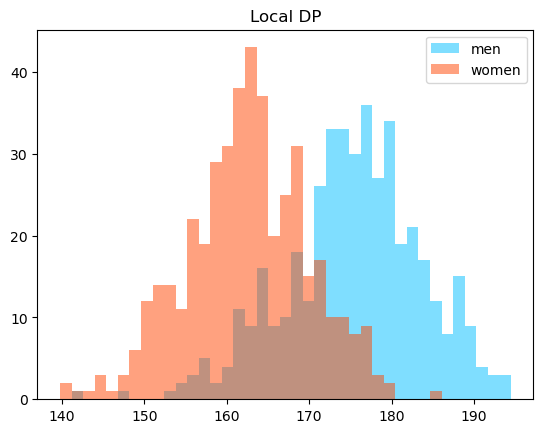

In [53]:
womenQuery = """
    SELECT ROUND(AVG(CAST(o.value AS DECIMAL))) as height, p.patient
    FROM observations o
    JOIN patients p ON p.patient = o.patient
    WHERE o.description = 'Body Height' AND p.gender = 'F' AND p.birthdate < '2000'
    GROUP BY o.patient
"""

menQuery = """
    SELECT ROUND(AVG(CAST(o.value AS DECIMAL)))  as height, p.patient
    FROM observations o
    JOIN patients p ON p.patient = o.patient
    WHERE o.description = 'Body Height' AND p.gender = 'M' AND p.birthdate < '2000'
    GROUP BY o.patient
"""

cur.execute(womenQuery)
women = cur.fetchall()
cur.execute(menQuery)
men = cur.fetchall()
men2 = []
women2 = []
for m in men:
    men2.append(m[0])
for w in women:
    women2.append(w[0])

menDeviation = 3
womenDeviation = 3
men3 = []
women3 = []

for m in men:
    men3.append(np.random.normal(m[0], menDeviation))
for w in women:
    women3.append(np.random.normal(w[0], womenDeviation))

import matplotlib.pyplot as plt
import numpy

bins = numpy.linspace(
    min(min(women2), min(men2)),
    max(max(women2), max(men2)),
    40)
plt.hist(men2, bins, label='men', alpha=0.5, color='deepskyblue')

plt.hist(women2, bins, label='women', alpha=0.5, color='orangered')

plt.legend()
plt.title('Real')
plt.show()

bins = numpy.linspace(
    min(min(women3), min(men3)),
    max(max(women3), max(men3)),
    40)
plt.hist(men3, bins, label='men', alpha=0.5, color='deepskyblue')

plt.hist(women3, bins, label='women', alpha=0.5, color='orangered')

plt.legend()
plt.title('Local DP')
plt.show()

In [51]:
import pandas as pd
menDf = pd.read_sql_query(menQuery, conn)
womenDf = pd.read_sql_query(womenQuery, conn)

metadata = {
    '':{
        '': {
            'MyTable': {
                'max_ids': 1,
                'row_privacy': True,
                'patient': {
                    'name': 'patient',
                    'type': 'string'
                },
                'height': {
                    'name': 'height',
                    'type': 'int'
                }
            }
        }
    }
}

import snsql
from snsql import Privacy
privacy = Privacy(epsilon=0.5, delta=0.01)
menReader = snsql.from_connection(menDf, privacy=privacy, metadata=metadata)
menResult = menReader.execute('SELECT height, COUNT(patient) as amount FROM MyTable GROUP BY height')
womenReader = snsql.from_connection(womenDf, privacy=privacy, metadata=metadata)
womenResult = womenReader.execute('SELECT height, COUNT(patient) as amount FROM MyTable GROUP BY height')

/Users/lukas/opt/anaconda3/lib/python3.9/site-packages/snsql/sql/private_reader.py:121: UserWarning: Dimension censoring is enabled, with Mechanism.discrete_laplace as the thresholding mechanism. 
This is an unsafe floating point mechanism.  Counts used for censoring will be revealed in any queries that request COUNT DISTINCT(person), 
leading to potential privacy leaks. If your query workload needs to reveal distinct counts of individuals, consider doing the dimension
censoring as a preprocessing step.  See the documentation for more information.
  warnings.warn(
/Users/lukas/opt/anaconda3/lib/python3.9/site-packages/snsql/sql/private_reader.py:121: UserWarning: Dimension censoring is enabled, with Mechanism.discrete_laplace as the thresholding mechanism. 
This is an unsafe floating point mechanism.  Counts used for censoring will be revealed in any queries that request COUNT DISTINCT(person), 
leading to potential privacy leaks. If your query workload needs to reveal distinct counts 

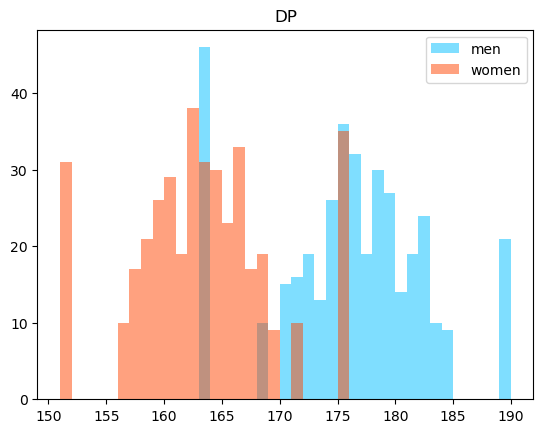

In [50]:
def dupe(a):
    acc = []
    amount = a[1]
    for x in range(amount):
        acc.append(a[0] * 1.0)
    return acc

men4 = []
for x in menResult[1:]:
    men4.extend(dupe(x))

women4 = []
for x in womenResult[1:]:
    women4.extend(dupe(x))

bins = numpy.linspace(
    min(min(women4), min(men4)),
    max(max(women4), max(men4)),
    40)
plt.hist(men4, bins, label='men', alpha=0.5, color='deepskyblue')

plt.hist(women4, bins, label='women', alpha=0.5, color='orangered')

plt.legend()
plt.title('DP')
plt.show()
